In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

In [3]:
import datetime as dt
import gmaps 
from config import gkey

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine,reflect=True)


# Database exploration

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [10]:
#Measurement and Station table columns
print(f'Measurement table columns: {measurements.__table__.columns.keys()}')
print(f'Station table columns: {stations.__table__.columns.keys()}')


Measurement table columns: ['id', 'station', 'date', 'prcp', 'tobs']
Station table columns: ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [11]:
# Measurement table exploration
maxdate = session.query(func.max(measurements.date))[0][0]
mindate = session.query(func.min(measurements.date))[0][0]
databaselength = session.query(func.count(measurements.date))[0][0]


print(f"Measurment table's most recent date: {maxdate}")
print(f"Measurment table's oldest date: {mindate}")
print(f"The Measurement table has {databaselength} records.")

Measurment table's most recent date: 2017-08-23
Measurment table's oldest date: 2010-01-01
The Measurement table has 19550 records.


# Precipitation Analysis

In [12]:
# Casting the year, month, and day into integers 
# to be used in the query date variable
year = int(maxdate[:4])
month = int(maxdate[5:7])
day = int(maxdate[8:10])


In [13]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(year,month,day) - dt.timedelta(days=365)
prcp_at_station = "USC00519281"

# Design a query to retrieve the last 12 months of precipitation data
last12months = session.query(measurements.date,measurements.prcp).\
    filter(measurements.date >= query_date).\
    filter(measurements.station == prcp_at_station).all()

# Save the query results as a Pandas DataFrame,sort the df by date and set the index to the date column
df = pd.DataFrame(last12months).sort_values('date')
df = df.rename(columns={'prcp':'precipitation'})
df['date'] = pd.to_datetime(df.date)

x = df.date
y = df.precipitation




## ATTN NOTE ##
# This dataframe contains the precipitation data and dates for the specified station.
# In terms of the whole dataset, the end-date is 8-23-2017. However, not every station
# contains precipitation data to the actual end date. Therefore, the end date for this station
# 8-18-2017 and the df contains 352 records of data. That being said, I decided 
# that I wanted to visualize precipitation over the last year for each individual station, 
# not an average precipitation across all stations. In order to obtain a dataframe with the 
# actual last date, the following commented steps would need to be taken. 

last12monthsall = session.query(measurements.date,measurements.prcp).\
    filter(measurements.date >= query_date).all()
last12monthsall_df = pd.DataFrame(last12monthsall,columns=["date", "avg_precipitation"])

# displaying df of precipitation data for last 12 months from station denoted above
df


,date,precipitation
0,2016-08-23,1.79
1,2016-08-24,2.15
2,2016-08-25,0.06
3,2016-08-26,0.01
4,2016-08-27,0.12
...,...,...
347,2017-08-14,0.00
348,2017-08-15,0.32
349,2017-08-16,0.12
350,2017-08-17,0.01


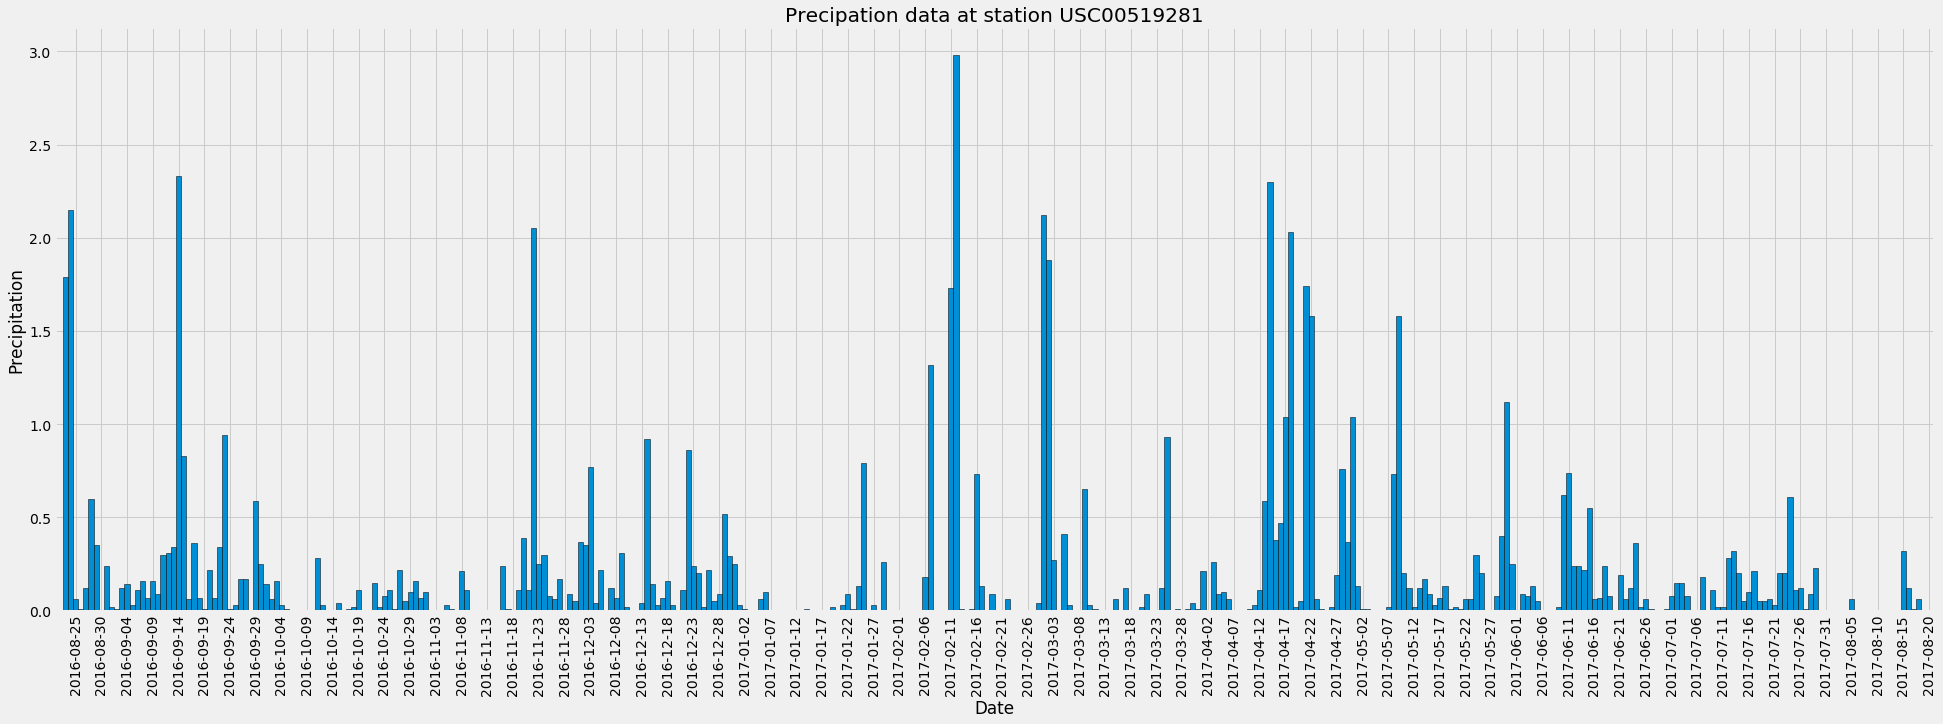

In [14]:
# Plotting last 12 months of precipitation data for the chosen station
fig = plt.figure(figsize=(30,10))
ax = plt.subplot(111)
ax.bar(x,y,width=1,edgecolor = 'black')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title(f"Precipation data at station {prcp_at_station}")
plt.xlim(pd.to_datetime("2016-08-21"),pd.to_datetime("2017-08-21"))

plt.show()


In [15]:
# Creating bins to better visualize the 12 months of precipitation data
bins = pd.cut(x,20)

dfbins = pd.DataFrame({"date":x,"Precipitation":y,"bins":bins})

dfbins["left"] = [x.left.strftime('%Y-%m-%d') for x in dfbins["bins"]]


dfbins["right"] = [x.right.strftime('%Y-%m-%d') for x in dfbins["bins"]]
dfbins["right"]

dfbins['interval'] = dfbins['left'] + " to "  + dfbins['right']

dfbins

,date,Precipitation,bins,left,right,interval
0,2016-08-23,1.79,"(2016-08-22 15:21:36, 2016-09-10]",2016-08-22,2016-09-10,2016-08-22 to 2016-09-10
1,2016-08-24,2.15,"(2016-08-22 15:21:36, 2016-09-10]",2016-08-22,2016-09-10,2016-08-22 to 2016-09-10
2,2016-08-25,0.06,"(2016-08-22 15:21:36, 2016-09-10]",2016-08-22,2016-09-10,2016-08-22 to 2016-09-10
3,2016-08-26,0.01,"(2016-08-22 15:21:36, 2016-09-10]",2016-08-22,2016-09-10,2016-08-22 to 2016-09-10
4,2016-08-27,0.12,"(2016-08-22 15:21:36, 2016-09-10]",2016-08-22,2016-09-10,2016-08-22 to 2016-09-10
...,...,...,...,...,...,...
347,2017-08-14,0.00,"(2017-07-31, 2017-08-18]",2017-07-31,2017-08-18,2017-07-31 to 2017-08-18
348,2017-08-15,0.32,"(2017-07-31, 2017-08-18]",2017-07-31,2017-08-18,2017-07-31 to 2017-08-18
349,2017-08-16,0.12,"(2017-07-31, 2017-08-18]",2017-07-31,2017-08-18,2017-07-31 to 2017-08-18
350,2017-08-17,0.01,"(2017-07-31, 2017-08-18]",2017-07-31,2017-08-18,2017-07-31 to 2017-08-18


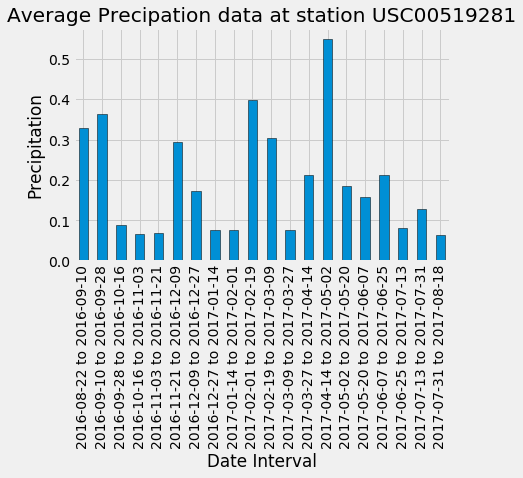

In [16]:
# Plotting last 12 months of precipitation data for the chosen station with bins
dfbins = dfbins.groupby('interval').mean()
dfbins.plot(kind='bar',legend=False,edgecolor='black')
plt.title(f"Average Precipation data at station {prcp_at_station}")
plt.ylabel("Precipitation")
plt.xlabel("Date Interval")
plt.grid(which='minor',axis='x')
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data from the chosen station
last12monthsall_df.describe()

,avg_precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis


In [18]:
# Design a query to show how many stations are available in this dataset
stationcode = session.query(measurements.station).group_by(measurements.station).all()
print(f'There are {len(stationcode)} stations.')

There are 9 stations.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationcount = session.query(measurements.station,func.count(measurements.station)).\
    group_by(measurements.station).\
    order_by(func.count(measurements.station).desc()).all()

stationcount 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
#station with the most observations
stationmost = session.query(measurements.station,func.count(measurements.station)).\
    group_by(measurements.station).\
    order_by(func.count(measurements.station).desc()).first()
print(f'Station {stationmost[0]} has the most observations of {stationmost[1]}')

Station USC00519281 has the most observations of 2772


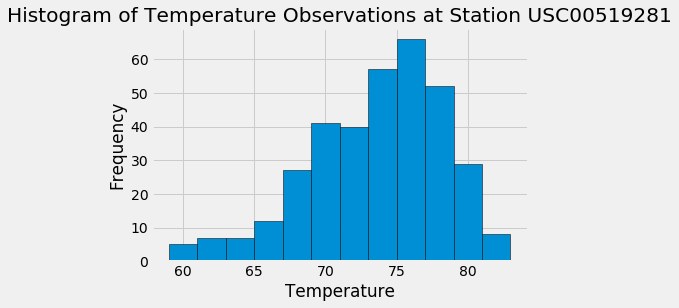

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_date = dt.date(year,month,day) - dt.timedelta(days=365)

last_12_months_temp_at_staion_most = session.query(measurements.date,measurements.tobs).\
    filter(measurements.date > query_date).\
    filter(measurements.station == stationmost[0]).all()

last12df = pd.DataFrame(last_12_months_temp_at_staion_most)

last12df.plot.hist(by=last12df.tobs,bins=12,legend=False,edgecolor='black')
plt.xlabel("Temperature")
plt.title(f"Histogram of Temperature Observations at Station {stationmost[0]}")
plt.show()


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowtemp = session.query(func.min(measurements.tobs)).\
    filter(measurements.station==stationmost[0]).scalar()
hightemp = session.query(func.max(measurements.tobs)).\
    filter(measurements.station==stationmost[0]).scalar()
avgtemp = session.query(func.avg(measurements.tobs)).\
    filter(measurements.station==stationmost[0]).all()

print(f"Station {stationmost[0]} lowest recorded temperature was {lowtemp} Degrees F")
print(f"Station {stationmost[0]} highest recorded temperature was {hightemp} Degrees F")
print(f"Station {stationmost[0]} average recorded temperature was {round(avgtemp[0][0],2)} Degrees F")

Station USC00519281 lowest recorded temperature was 54.0 Degrees F
Station USC00519281 highest recorded temperature was 85.0 Degrees F
Station USC00519281 average recorded temperature was 71.66 Degrees F


## Data manipulation for GMAPS plot of stations



In [23]:
station_name_code = session.query(stations.station,stations.name,stations.latitude,stations.longitude).group_by(stations.name).all()
station_name_code

station_df = pd.DataFrame(station_name_code)
station_df

,station,name,latitude,longitude
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889
7,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680
8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139


In [24]:
# Creating a list of lists of the coordinates for the stations
coordinates = station_df[["latitude", "longitude"]].values.tolist()
coordinates

[[21.3152, -157.9992],
 [21.4234, -157.8015],
 [21.5213, -157.8374],
 [21.3331, -157.8025],
 [21.3934, -157.9751],
 [21.4992, -158.0111],
 [21.45167, -157.84888999999998],
 [21.2716, -157.8168],
 [21.33556, -157.71139]]

In [25]:
# Using Gmaps to plot locations of the stations

fig = gmaps.figure()


info_box_template = """
<dl>
<dt>Station code</dt><dd>{station}</dd>
<dt>Station name</dt><dd>{name}</dd>
<dt>Latitude</dt><dd>{latitude}</dd>
<dt>Longitude</dt><dd>{longitude}</dd>
</dl>
"""

# Store the DataFrame Row
station_info = [info_box_template.format(**row) for index, row in station_df.iterrows()]

#Add marker layer
markers = gmaps.marker_layer(coordinates,info_box_content=[f'Station Details: {info}' for info in station_info])
fig.add_layer(markers)
fig


Figure(layout=FigureLayout(height='420px'))